In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from pathlib import Path
from omegaconf import OmegaConf

from sklearn.model_selection import train_test_split

from sklearn.metrics import f1_score, roc_curve, auc
from sklearn.metrics import precision_score, recall_score, f1_score

from data import load_dataset

In [2]:
PROJECT_DIR = Path.cwd().parent
DATA_DIR = PROJECT_DIR / "data"
CONFIG_DIR = PROJECT_DIR / "configs"

In [3]:
cfg = OmegaConf.load(CONFIG_DIR / "config.yaml")

In [4]:
ds = load_dataset(DATA_DIR)

/Users/anatolii/Projects/ml-engineering/titanic-survivors/data/Titanic-Dataset.csv
File Titanic-Dataset.csv already exists in /Users/anatolii/Projects/ml-engineering/titanic-survivors/data


In [5]:
target = cfg.data.target
X = ds.drop(columns=[target])
y = ds[target].astype(int) # convert bool to int
X_train, X_val, y_train, y_val = train_test_split(X, y, 
                                                    test_size=cfg.data.test_size, 
                                                    random_state=cfg.data.random_state, 
                                                    stratify=y, 
                                                    shuffle=cfg.data.shuffle)

In [6]:
import mlflow.sklearn
mlflow.set_tracking_uri((PROJECT_DIR / "mlruns").as_uri())
run_id = "de1aa17e14794d5a9aeeb7849f518fb2"

model = mlflow.sklearn.load_model(
    f"runs:/{run_id}/model"
)

/Users/anatolii/Projects/ml-engineering/titanic-survivors/.venv/lib/python3.11/site-packages/mlflow/tracking/_tracking_service/utils.py:178: FutureWarning: The filesystem tracking backend (e.g., './mlruns') will be deprecated in February 2026. Consider transitioning to a database backend (e.g., 'sqlite:///mlflow.db') to take advantage of the latest MLflow features. See https://github.com/mlflow/mlflow/issues/18534 for more details and migration guidance. For migrating existing data, https://github.com/mlflow/mlflow-export-import can be used.
  return FileStore(store_uri, store_uri)


MlflowException: Failed to download artifacts from path 'model', please ensure that the path is correct.

In [ ]:
y_pred = model.predict(X_val)
y_proba = model.predict_proba(X_val)[:, 1]

In [ ]:
def plot_roc_curve(y_true, y_proba):
    fpr, tpr, thresholds = roc_curve(y_true, y_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, 
             label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', 
             label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.show()

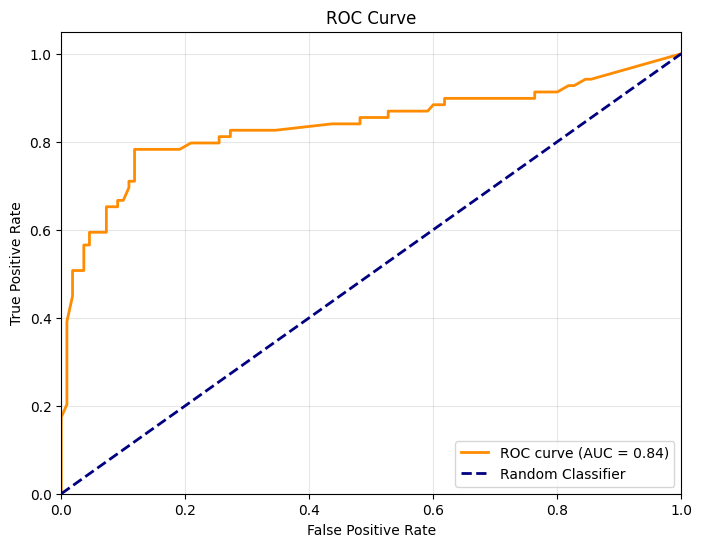

In [ ]:
plot_roc_curve(y_val, y_proba)

In [ ]:
def sweep_thresholds(y_true, proba, thresholds=None):
    if thresholds is None:
        thresholds = np.linspace(0.05, 0.95, 19)  # coarse grid
    rows = []
    for t in thresholds:
        pred = (proba >= t).astype(int)
        rows.append({
            "t": float(t),
            "precision": float(precision_score(y_true, pred, zero_division=0)),
            "recall": float(recall_score(y_true, pred)),
            "f1": float(f1_score(y_true, pred)),
        })
    return rows

In [ ]:
row = sweep_thresholds(y_val, y_proba)

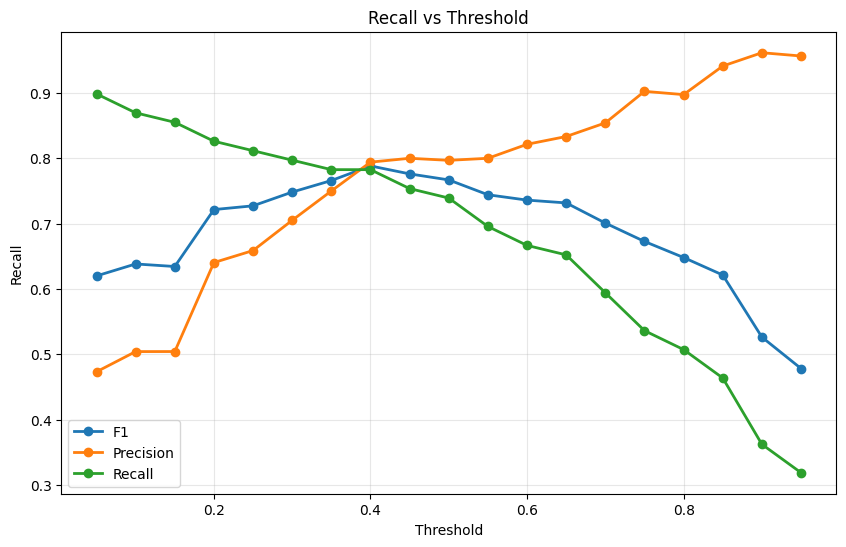

In [ ]:
# Extract data from rows
thresholds = [r['t'] for r in row]
recalls = [r['recall'] for r in row]
precisions = [r['precision'] for r in row]
f1_scores = [r['f1'] for r in row]

# Plot recall vs threshold
plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores, marker='o', label='F1', linewidth=2)
plt.plot(thresholds, precisions, marker='o', label='Precision', linewidth=2)
plt.plot(thresholds, recalls, marker='o', label='Recall', linewidth=2)
plt.xlabel('Threshold')
plt.ylabel('Recall')
plt.title('Recall vs Threshold')
plt.grid(alpha=0.3)
plt.legend()
plt.show()

In [ ]:
# Get indices of false positives and false negatives
fp_indices = []
fn_indices = []

for i in range(len(y_val)):
    if y_val.iloc[i] != y_pred[i]:
        if y_pred[i] == 0:
            fn_indices.append(i)  # False Negative (predicted died, actually survived)
        else:
            fp_indices.append(i)  # False Positive (predicted survived, actually died)

# Access corresponding rows in X_val
X_val_fp = X_val.iloc[fp_indices]
X_val_fn = X_val.iloc[fn_indices]

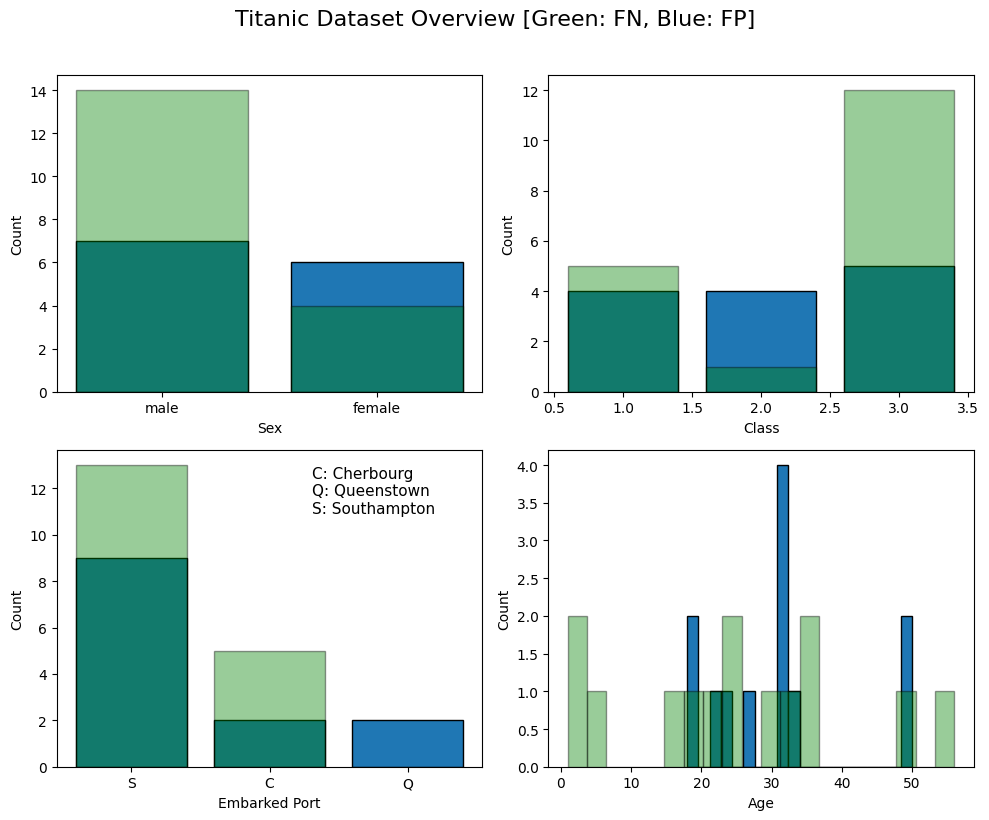

In [ ]:
fig, axs = plt.subplots(2,2, figsize=(10,8))
colors = sns.color_palette("tab10")

# Sex distribution
sex_counts = X_val_fp['Sex'].value_counts()
sex_counts_survived = X_val_fn['Sex'].value_counts()
axs[0,0].bar(sex_counts.index, sex_counts.values, edgecolor='black')
axs[0,0].bar(sex_counts_survived.index, sex_counts_survived.values, edgecolor='black', color='green', alpha=0.4)
axs[0,0].set_xlabel('Sex')
axs[0,0].set_ylabel('Count')


# Passanger's class distributiuon
pclass_counts = X_val_fp['Pclass'].value_counts()
pclass_counts_survived = X_val_fn['Pclass'].value_counts()
axs[0,1].bar(pclass_counts.index, pclass_counts.values, edgecolor='black')
axs[0,1].bar(pclass_counts_survived.index, pclass_counts_survived.values, edgecolor='black', color='green', alpha=0.4)
axs[0,1].set_xlabel('Class')
axs[0,1].set_ylabel('Count')


# Embarked port
embarked_counts = X_val_fp['Embarked'].value_counts()
embarked_counts_survived = X_val_fn['Embarked'].value_counts()
axs[1,0].bar(embarked_counts.index, embarked_counts.values, edgecolor='black')
axs[1,0].bar(embarked_counts_survived.index, embarked_counts_survived.values, edgecolor='black', color='green', alpha=0.4)
axs[1,0].set_xlabel('Embarked Port')
axs[1,0].set_ylabel('Count')
port_desc = 'C: Cherbourg\nQ: Queenstown\nS: Southampton'
axs[1,0].text(0.6, 0.95, port_desc, transform=axs[1,0].transAxes,
              fontsize=11, verticalalignment='top', horizontalalignment='left')

axs[1,1].hist(X_val_fp['Age'].dropna(), bins=20 ,edgecolor='black')
axs[1,1].set_xlabel('Age')
axs[1,1].set_ylabel('Count')
axs[1,1].hist(X_val_fn['Age'].dropna(), bins=20, edgecolor='black', color='green', alpha=0.4, label='Survived')

fig.suptitle('Titanic Dataset Overview [Green: FN, Blue: FP]', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

### Test Model

In [ ]:
# test on my data
my_data = pd.DataFrame({
    'PassengerId': [999],
    'Pclass': [1],           # 1st, 2nd, or 3rd class
    'Name': ['John Doe'],
    'Sex': ['male'],         # 'male' or 'female'
    'Age': [26],             # age in years
    'SibSp': [1],            # number of siblings/spouses
    'Parch': [0],            # number of parents/children
    'Ticket': ['A/5 21171'],
    'Fare': [7.25],
    'Cabin': [None],
    'Embarked': ['C']        # 'C', 'Q', or 'S'
})

In [ ]:
# Make prediction
my_pred = model.predict(my_data)
my_proba = model.predict_proba(my_data)[:, 1]

In [ ]:
print(f"Prediction: {'Survived' if my_pred[0] == 1 else 'Died'}")
print(f"Survival probability: {my_proba[0]:.2%}")

Prediction: Survived
Survival probability: 71.00%
